In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sys
if "/content/drive/My Drive/Machine Learning/lib/" not in sys.path:
    sys.path.append("/content/drive/My Drive/Machine Learning/lib/") 

In [0]:
from envs.blackjack import BlackjackEnv
import plotting

import gym
import numpy as np
from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline

## GLIE Monte-Carlo Control

- Using Monte Carlo control.(使用MC方法)
- 使用MC方法对Q进行估计
- 使用$\epsilon$-greedy exploration的方法进行更新策略
    

### 初始化环境

In [0]:
environment = BlackjackEnv()

In [0]:
# 这个环境中可能动作的个数
nA = environment.action_space.n
print(nA)

2


In [0]:
# 这个表示对于每一个state, 会增加两个值, 分别表示Q(state, action)的值
Q = defaultdict(lambda: np.zeros(nA))
# 可以看到默认会返回两个值
Q[1] = Q[2] + Q[3]
print(Q)

defaultdict(<function <lambda> at 0x7ff3113a12f0>, {2: array([0., 0.]), 3: array([0., 0.]), 1: array([0., 0.])})


In [0]:
# 按照概率选择动作
np.random.choice([1,2],p=[0.1,0.9])

2

In [0]:
# 概率大的一个动作
np.argmax([0.95,0.05])

0

In [0]:
episode = ((1,0),(2,1),(2,1),(1,0))
state = 2
action = 1
next(i for i,x in enumerate(episode) if x[0] == state and x[1] == action)

1

### 创建epsilon-greedy policy

$$
\pi(a|s)=
\left\{
    \begin{aligned}
        & \frac{\epsilon}{m}+1-\epsilon \quad if \; a*=argmax_{a \in A}(q(s,a)) \\
        & \frac{\epsilon}{m} \quad otherwise
    \end{aligned}
\right.
$$

In [0]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: 采取一个随机动作的概率.
        nA: 一个环境中可以采取的动作的个数(此时动作为离散的).
        times: 迭代的次数
    Returns:
        返回的是每一个动作出现的概率.
    
    """
    
    def policy_fn(observation):
        # 看到这个state之后, 采取不同action获得的累计奖励
        action_values = Q[observation]
        # 使用获得奖励最大的那个动作
        greedy_action = np.argmax(action_values)
        # 是的每个动作都有出现的可能性
        probabilities = np.ones(nA) /nA * epsilon
        # 最好的那个动作的概率会大一些
        probabilities[greedy_action] = probabilities[greedy_action] + (1 - epsilon)
        
        return probabilities
        
    return policy_fn 

### GLIE Monte-Carlo Control

- 在第k轮的迭代中(kth episode), 我们使用策略$\pi$得到了$\{S_{1}, A_{1}, R_{2}, \cdots, S_{T}\}$;
- 对于每一个状态$S$, 和动作$A$二元组, $\{S_{t}, A_{t}\}$, 我们进行如下操作(更新Q):
    - $N(S_{t}, A_{t}) \leftarrow N(S_{t}, A_{t}) + 1$, 出现次数+1;
    - $Q(S_{t}, A_{t}) \leftarrow Q(S_{t}, A_{t}) + \frac{1}{N(S_{t}, A_{t})} (G_{t}-Q(S_{t}, A_{t}))$, 使用incremental mean;
- 更新策略, $\pi \leftarrow \epsilon-greedy(Q)$


### 评价一个策略的Q与更新策略

In [0]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns action probabilities
    """
    
    returns_sum = defaultdict(float) # 记录(state, action)对的累计reward
    returns_count = defaultdict(float) # 记录(state, action)对出现次数
    
    # 环境中所有动作的数量
    nA = env.action_space.n

    # 初始化Q表
    Q = defaultdict(lambda: np.zeros(nA))
    
    # 初始化polict
    policy = make_epsilon_greedy_policy(Q, epsilon, nA)
    
    for i_episode in range(1, num_episodes + 1):
        # 每1000次打印以下.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # 开始一个episode, 开始一局游戏
        episode = [] # 这里包括((state,action,reward), (state,action,reward), ...)
        state = env._reset()
        while True:
            probs = policy(state) # 返回看到这个state之后, 采取的action的概率
            action = np.random.choice(np.arange(len(probs)), p=probs) # 根据概率采取行动
            next_state, reward, done, _ = env._step(action) # 执行action, 返回reward和下一步的状态
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # Find all (state, action) pairs we've visited in this episode
        # 更新了Q之后, 策略也就更新了
        # 更新一次Q, 就更新策略, 用新的策略做实验
        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode]) # 只取出(state, action)
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            # 找到第一次(state,action)出现的位置
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == state and x[1] == action)
            # 第一次出现之后, 的累计的奖励
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # Calculate average return for this state over all sampled episodes
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]
        
        # The policy is improved implicitly by changing the Q dictionary
    
    return Q, policy

### 评价上面的policy且进行可视化

In [0]:
Q, policy = mc_control_epsilon_greedy(environment, num_episodes=2700000, discount_factor=0.9, epsilon=0.1)

Episode 2700000/2700000.

In [0]:
# 给出一个state, 查看给出每个action的动作
policy((12, 4, False))

array([0.95, 0.05])

In [0]:
Q

defaultdict(<function __main__.mc_control_epsilon_greedy.<locals>.<lambda>>,
            {(12, 1, False): array([-0.77219167, -0.51320247]),
             (12, 1, True): array([-0.69767442, -0.2746601 ]),
             (12, 2, False): array([-0.29160021, -0.30458926]),
             (12, 2, True): array([-0.35211268,  0.09675446]),
             (12, 3, False): array([-0.25428159, -0.26440577]),
             (12, 3, True): array([-0.17460317,  0.07072831]),
             (12, 4, False): array([-0.20059999, -0.31503263]),
             (12, 4, True): array([-0.20183486,  0.16814118]),
             (12, 5, False): array([-0.16745906, -0.21207223]),
             (12, 5, True): array([-0.22857143,  0.14292578]),
             (12, 6, False): array([-0.15772067, -0.17114359]),
             (12, 6, True): array([-0.06306306,  0.17411594]),
             (12, 7, False): array([-0.47068677, -0.24636745]),
             (12, 7, True): array([-0.47663551,  0.11245867]),
             (12, 8, False): array

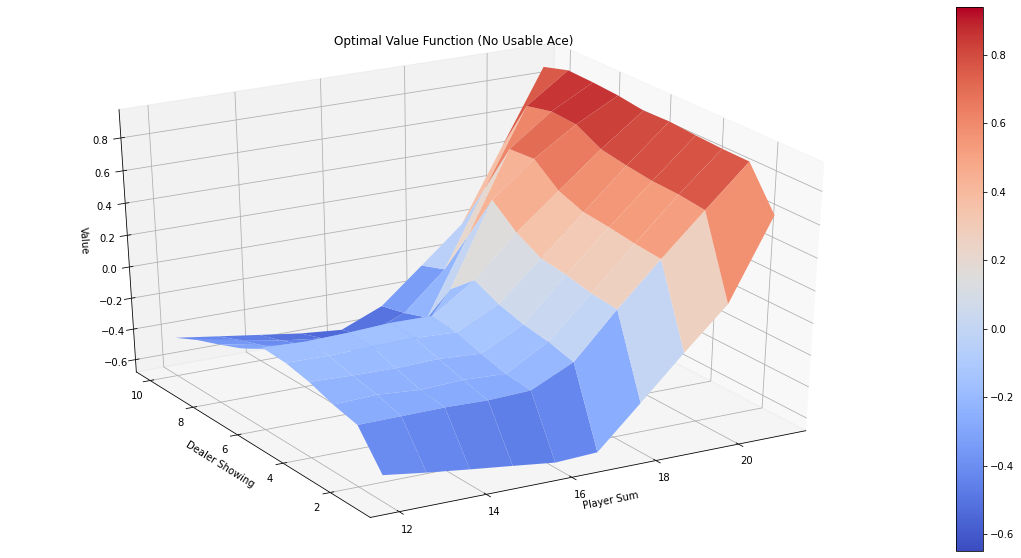

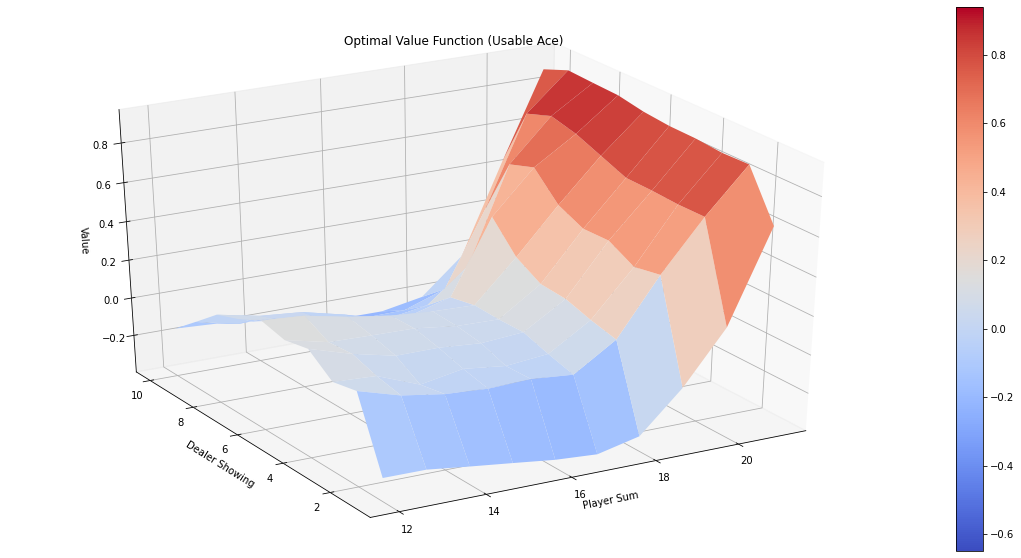

In [0]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions) # 选取最大的action对应的那个reward
    V[state] = action_value # 从而有了V((14, 7, False))的值
plotting.plot_value_function(V, title="Optimal Value Function")

- request additional cards (hit=1), 1表示要牌
- stop (stick=0), 0表示不要牌

[[1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]]


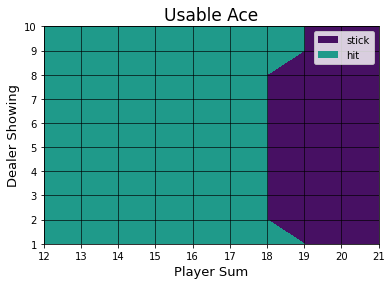

In [0]:
x, y = np.meshgrid(np.arange(12,22), np.arange(1,11))
z = np.zeros(x.shape) # z存储执行的动作
# 计算z
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        probs=policy((x[i][j],y[i][j],True))
        action=np.argmax(probs)
        z[i][j]=action

print(z)

# --------
# 开始绘制
# --------
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# 绘制图形
ax.contourf(x,y,z,levels=[-0.1,0,1.1])

# 坐标轴注释
ax.set_xlabel("Player Sum", fontsize=13)
ax.set_ylabel("Dealer Showing", fontsize=13)

# 增加图例
proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in ax.collections]
plt.legend(proxy, ["stick", "hit"])

# 增加网格
ax.grid(which='major', color='black', alpha=0.8)
ax.grid(which='major', color='black', alpha=0.8)

ax.set_title(u'Usable Ace', fontsize=17)

plt.show()

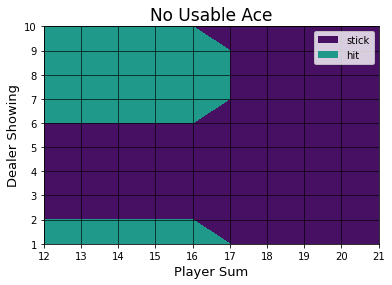

In [0]:
x, y = np.meshgrid(np.arange(12,22), np.arange(1,11))
z = np.zeros(x.shape) # z存储执行的动作
# 计算z
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        probs=policy((x[i][j],y[i][j],False))
        action=np.argmax(probs)
        z[i][j]=action


# --------
# 开始绘制
# --------
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# 绘制图形
ax.contourf(x,y,z,levels=[-0.1,0,1.1],corner_mask=False)

# 坐标轴注释
ax.set_xlabel("Player Sum", fontsize=13)
ax.set_ylabel("Dealer Showing", fontsize=13)

# 增加图例
proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in ax.collections]
plt.legend(proxy, ["stick", "hit"])

# 增加网格
ax.grid(which='major', color='black', alpha=0.8)
ax.grid(which='major', color='black', alpha=0.8)

ax.set_title(u'No Usable Ace', fontsize=17)

plt.show()